# Task 3: Forecast Future Market Trends
This notebook uses trained models to forecast Tesla's future stock prices and provides comprehensive analysis of trends, volatility, and risks


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import pickle
import os
import sys

# Add src directory to path
sys.path.append('../src')

# Import custom modules
try:
    from forecasting import ForecastingEngine
    from arima_model import ARIMAModel
    from lstm_model import LSTMForecaster
    from data_loader import DataLoader
    print("✅ All custom modules imported successfully!")
except ImportError as e:
    print(f"⚠️ Warning: Could not import some custom modules: {e}")
    print("Continuing with available functionality...")

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ Basic imports successful!")

✅ All custom modules imported successfully!
✅ Basic imports successful!


## 1. Load Tesla Data 

In [2]:
# Load Tesla stock data
print("📊 Loading Tesla stock data...")

# Load the enhanced Tesla data directly
tsla_data = pd.read_csv('../data/processed/TSLA_enhanced_data.csv')
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'])
tsla_data.set_index('Date', inplace=True)

# Use Close price for forecasting
tsla_close = tsla_data['Close']

print(f"📈 Data loaded successfully!")
print(f"   - Date range: {tsla_close.index[0].strftime('%Y-%m-%d')} to {tsla_close.index[-1].strftime('%Y-%m-%d')}")
print(f"   - Total observations: {len(tsla_close):,}")
print(f"   - Current price: ${tsla_close.iloc[-1]:.2f}")
print(f"   - Price range: ${tsla_close.min():.2f} - ${tsla_close.max():.2f}")

# Display recent data
tsla_close.tail()

📊 Loading Tesla stock data...
📈 Data loaded successfully!
   - Date range: 2015-09-25 to 2025-07-30
   - Total observations: 2,475
   - Current price: $319.04
   - Price range: $9.58 - $479.86


Date
2025-07-24 00:00:00-04:00    305.299988
2025-07-25 00:00:00-04:00    316.059998
2025-07-28 00:00:00-04:00    325.589996
2025-07-29 00:00:00-04:00    321.200012
2025-07-30 00:00:00-04:00    319.040009
Name: Close, dtype: float64

## 2. Load Trained Models

In [3]:
# Since pre-trained models have compatibility issues, let's create new models
print("🔄 Creating new forecasting models...")

# Create a simple ARIMA model
try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.stattools import adfuller
    
    # Check stationarity
    def check_stationarity(series):
        result = adfuller(series.dropna())
        return result[1] < 0.05
    
    # Make series stationary if needed
    tsla_stationary = tsla_close.copy()
    diff_count = 0
    max_diff = 2
    
    while not check_stationarity(tsla_stationary) and diff_count < max_diff:
        tsla_stationary = tsla_stationary.diff().dropna()
        diff_count += 1
    
    print(f"�� Stationarity check: {diff_count} differences applied")
    
    # Use a simpler, more robust ARIMA model
    try:
        # First try a simple ARIMA(1,1,0) model
        arima_model = ARIMA(tsla_close, order=(1, 1, 0))
        arima_fitted = arima_model.fit()
        print(f"✅ Simple ARIMA model created (order: 1,1,0)")
    except:
        # If that fails, try ARIMA(0,1,1)
        try:
            arima_model = ARIMA(tsla_close, order=(0, 1, 1))
            arima_fitted = arima_model.fit()
            print(f"✅ Simple ARIMA model created (order: 0,1,1)")
        except:
            # Last resort: ARIMA(1,1,1) with different fitting method
            arima_model = ARIMA(tsla_close, order=(1, 1, 1))
            arima_fitted = arima_model.fit(method='lbfgs', maxiter=1000)
            print(f"✅ ARIMA model created (order: 1,1,1) with alternative fitting")
    
    # Validate the fitted model
    print(f"�� ARIMA model AIC: {arima_fitted.aic:.2f}")
    print(f"�� ARIMA model BIC: {arima_fitted.bic:.2f}")
    
    # Test forecast capability
    test_forecast = arima_fitted.forecast(steps=5)
    print(f"🧪 Test forecast (5 steps): {test_forecast[:3].tolist()}... (first 3 values)")
    
except Exception as e:
    print(f"❌ Could not create ARIMA model: {e}")
    arima_model = None
    arima_fitted = None

# Create a simple LSTM model
try:
    # Prepare data for LSTM
    from sklearn.preprocessing import MinMaxScaler
    
    # Scale the data
    scaler = MinMaxScaler()
    tsla_scaled = scaler.fit_transform(tsla_close.values.reshape(-1, 1))
    
    # Create sequences
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:(i + seq_length)])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)
    
    seq_length = 20
    X, y = create_sequences(tsla_scaled, seq_length)
    
    # Simple LSTM model using PyTorch
    import torch
    import torch.nn as nn
    
    class SimpleLSTM(nn.Module):
        def __init__(self, input_size=1, hidden_size=50, num_layers=2):
            super(SimpleLSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, 1)
        
        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
            out, _ = self.lstm(x, (h0, c0))
            out = self.fc(out[:, -1, :])
            return out
    
    # Create and train LSTM model
    lstm_model = SimpleLSTM()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters())
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    # Train for a few epochs
    lstm_model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        outputs = lstm_model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
    
    lstm_model.eval()
    print("✅ New LSTM model created and trained")
    
except Exception as e:
    print(f"❌ Could not create LSTM model: {e}")
    lstm_model = None
    scaler = None

print(f"�� Models created: ARIMA={'✅' if arima_fitted else '❌'}, LSTM={'✅' if lstm_model else '❌'}")

# Additional validation for ARIMA model
if arima_fitted:
    print("\n🔍 ARIMA Model Validation:")
    try:
        # Check if model has forecast method
        if hasattr(arima_fitted, 'forecast'):
            print("✅ ARIMA model has forecast method")
            
            # Test forecast with different steps
            for steps in [1, 5, 10]:
                try:
                    test_fc = arima_fitted.forecast(steps=steps)
                    print(f"✅ {steps}-step forecast successful: {test_fc[:2].tolist()}...")
                except Exception as e:
                    print(f"❌ {steps}-step forecast failed: {e}")
        else:
            print("❌ ARIMA model missing forecast method")
            
        # Check if model has get_forecast method for confidence intervals
        if hasattr(arima_fitted, 'get_forecast'):
            print("✅ ARIMA model has get_forecast method for confidence intervals")
        else:
            print("❌ ARIMA model missing get_forecast method")
            
    except Exception as e:
        print(f"❌ ARIMA validation failed: {e}")

🔄 Creating new forecasting models...
�� Stationarity check: 1 differences applied
✅ Simple ARIMA model created (order: 1,1,0)
�� ARIMA model AIC: 16735.76
�� ARIMA model BIC: 16747.39
🧪 Test forecast (5 steps): [319.0725381702026, 319.0720482744957, 319.0720556523183]... (first 3 values)
✅ New LSTM model created and trained
�� Models created: ARIMA=✅, LSTM=✅

🔍 ARIMA Model Validation:
✅ ARIMA model has forecast method
✅ 1-step forecast successful: [319.0725381702026]...
✅ 5-step forecast successful: [319.0725381702026, 319.0720482744957]...
✅ 10-step forecast successful: [319.0725381702026, 319.0720482744957]...
✅ ARIMA model has get_forecast method for confidence intervals


## 3. Generate Future Forecasts (6-12 months)

In [4]:
# Generate future forecasts for 6-12 months
print("🔮 Generating future forecasts...")

# Calculate forecast periods (6 months = ~126 trading days, 12 months = ~252 trading days)
forecast_6m = 126
forecast_12m = 252

# Generate forecasts for both periods
forecasts_6m = {}
forecasts_12m = {}

# ARIMA forecasts
if arima_fitted:
    print("📊 Generating ARIMA forecasts...")
    
    try:
        # 6-month forecast
        arima_forecast_6m = arima_fitted.forecast(steps=forecast_6m)
        forecasts_6m['ARIMA'] = pd.Series(arima_forecast_6m)
        
        # 12-month forecast
        arima_forecast_12m = arima_fitted.forecast(steps=forecast_12m)
        forecasts_12m['ARIMA'] = pd.Series(arima_forecast_12m)
        
        print("✅ ARIMA forecasts generated")
    except Exception as e:
        print(f"❌ Error generating ARIMA forecasts: {e}")

# LSTM forecasts
if lstm_model:
    print("🧠 Generating LSTM forecasts...")
    
    try:
        # Prepare last sequence for forecasting
        last_sequence = tsla_scaled[-seq_length:].reshape(1, seq_length, 1)
        last_sequence_tensor = torch.FloatTensor(last_sequence)
        
        # Generate forecasts step by step
        lstm_forecast_6m = []
        lstm_forecast_12m = []
        
        current_sequence = last_sequence.copy()
        
        # 6-month forecast
        for _ in range(forecast_6m):
            current_tensor = torch.FloatTensor(current_sequence.reshape(1, seq_length, 1))
            with torch.no_grad():
                prediction = lstm_model(current_tensor)
            lstm_forecast_6m.append(prediction.item())
            
            # Update sequence for next prediction
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1] = prediction.item()
        
        # 12-month forecast
        current_sequence = last_sequence.copy()
        for _ in range(forecast_12m):
            current_tensor = torch.FloatTensor(current_sequence.reshape(1, seq_length, 1))
            with torch.no_grad():
                prediction = lstm_model(current_tensor)
            lstm_forecast_12m.append(prediction.item())
            
            # Update sequence for next prediction
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1] = prediction.item()
        
        # Convert back to original scale
        lstm_forecast_6m = scaler.inverse_transform(np.array(lstm_forecast_6m).reshape(-1, 1)).flatten()
        lstm_forecast_12m = scaler.inverse_transform(np.array(lstm_forecast_12m).reshape(-1, 1)).flatten()
        
        forecasts_6m['LSTM'] = pd.Series(lstm_forecast_6m)
        forecasts_12m['LSTM'] = pd.Series(lstm_forecast_12m)
        
        print("✅ LSTM forecasts generated")
    except Exception as e:
        print(f"❌ Error generating LSTM forecasts: {e}")

print(f"🎯 Forecasts generated for {len(forecasts_6m)} models")

🔮 Generating future forecasts...
📊 Generating ARIMA forecasts...
✅ ARIMA forecasts generated
🧠 Generating LSTM forecasts...
✅ LSTM forecasts generated
🎯 Forecasts generated for 2 models


## 4. Create Future Date Index

In [5]:
# Create future date index for forecasts
print("📅 Creating future date index...")

# Get last date from historical data
last_date = tsla_close.index[-1]

# Create future dates (business days only)
future_dates_6m = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=forecast_6m)
future_dates_12m = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=forecast_12m)

print(f"📆 6-month forecast dates: {future_dates_6m[0].strftime('%Y-%m-%d')} to {future_dates_6m[-1].strftime('%Y-%m-%d')}")
print(f"📆 12-month forecast dates: {future_dates_12m[0].strftime('%Y-%m-%d')} to {future_dates_12m[-1].strftime('%Y-%m-%d')}")

# Assign dates to forecasts
for model_name in forecasts_6m.keys():
    if isinstance(forecasts_6m[model_name], pd.Series):
        forecasts_6m[model_name].index = future_dates_6m
        forecasts_12m[model_name].index = future_dates_12m

print("✅ Future date indices created")

📅 Creating future date index...
📆 6-month forecast dates: 2025-07-31 to 2026-01-22
📆 12-month forecast dates: 2025-07-31 to 2026-07-17
✅ Future date indices created


## 5. Generate Confidence Intervals

In [6]:
# Generate confidence intervals for forecasts
print("📊 Generating confidence intervals...")

confidence_intervals = {}

# ARIMA confidence intervals (if available)
if 'ARIMA' in forecasts_6m:
    print("📈 Calculating ARIMA confidence intervals...")
    
    try:
        # Get ARIMA forecast with confidence intervals
        arima_forecast_6m_with_ci = arima_fitted.get_forecast(steps=forecast_6m)
        arima_forecast_12m_with_ci = arima_fitted.get_forecast(steps=forecast_12m)
        
        # Debug: Check what we're getting from get_forecast
        print(f"🔍 ARIMA 6m forecast type: {type(arima_forecast_6m_with_ci)}")
        print(f"🔍 ARIMA 6m forecast shape: {arima_forecast_6m_with_ci.predicted_mean.shape if hasattr(arima_forecast_6m_with_ci, 'predicted_mean') else 'No predicted_mean'}")
        
        # Extract confidence intervals with proper error handling
        try:
            # Method 1: Try to get confidence intervals directly
            arima_6m_ci = arima_forecast_6m_with_ci.conf_int()
            arima_12m_ci = arima_forecast_12m_with_ci.conf_int()
            
            print("✅ ARIMA confidence intervals extracted successfully")
            
            confidence_intervals['ARIMA_6m'] = {
                'forecast': pd.Series(arima_forecast_6m_with_ci.predicted_mean, index=future_dates_6m),
                'lower_ci': pd.Series(arima_6m_ci.iloc[:, 0], index=future_dates_6m),
                'upper_ci': pd.Series(arima_6m_ci.iloc[:, 1], index=future_dates_6m)
            }
            
            confidence_intervals['ARIMA_12m'] = {
                'forecast': pd.Series(arima_forecast_12m_with_ci.predicted_mean, index=future_dates_12m),
                'lower_ci': pd.Series(arima_12m_ci.iloc[:, 0], index=future_dates_12m),
                'upper_ci': pd.Series(arima_12m_ci.iloc[:, 1], index=future_dates_12m)
            }
            
        except Exception as ci_error:
            print(f"⚠️ Direct CI extraction failed: {ci_error}")
            
            # Method 2: Use the original forecasts and create simulated confidence intervals
            print("�� Creating simulated ARIMA confidence intervals...")
            
            arima_6m = forecasts_6m['ARIMA']
            arima_12m = forecasts_12m['ARIMA']
            
            # Calculate historical volatility for confidence intervals
            returns = tsla_close.pct_change().dropna()
            volatility = returns.rolling(window=20).std()
            current_volatility = volatility.iloc[-1]
            
            confidence_level = 0.95
            z_score = 1.96
            
            for period, forecast_data in [('6m', arima_6m), ('12m', arima_12m)]:
                # Create time-based confidence intervals
                time_factor = np.sqrt(np.arange(1, len(forecast_data) + 1))
                
                # Calculate confidence intervals based on volatility and time
                lower_ci = forecast_data * (1 - z_score * current_volatility * time_factor)
                upper_ci = forecast_data * (1 + z_score * current_volatility * time_factor)
                
                # Ensure lower CI doesn't go below 0 (stock prices can't be negative)
                lower_ci = np.maximum(lower_ci, 0)
                
                confidence_intervals[f'ARIMA_{period}'] = {
                    'forecast': forecast_data,
                    'lower_ci': pd.Series(lower_ci, index=forecast_data.index),
                    'upper_ci': pd.Series(upper_ci, index=forecast_data.index)
                }
            
            print("✅ Simulated ARIMA confidence intervals created")
        
        print("✅ ARIMA confidence intervals calculated")
        
    except Exception as e:
        print(f"⚠️ Could not calculate ARIMA confidence intervals: {e}")
        print("🔄 Falling back to simulated confidence intervals...")
        
        # Fallback: Create simple confidence intervals
        arima_6m = forecasts_6m['ARIMA']
        arima_12m = forecasts_12m['ARIMA']
        
        # Simulate confidence intervals based on historical volatility
        returns = tsla_close.pct_change().dropna()
        volatility = returns.rolling(window=20).std()
        current_volatility = volatility.iloc[-1]
        
        confidence_level = 0.95
        z_score = 1.96
        
        for period, forecast_data in [('6m', arima_6m), ('12m', arima_12m)]:
            # Create time-based confidence intervals
            time_factor = np.sqrt(np.arange(1, len(forecast_data) + 1))
            
            # Calculate confidence intervals based on volatility and time
            lower_ci = forecast_data * (1 - z_score * current_volatility * time_factor)
            upper_ci = forecast_data * (1 + z_score * current_volatility * time_factor)
            
            # Ensure lower CI doesn't go below 0
            lower_ci = np.maximum(lower_ci, 0)
            
            confidence_intervals[f'ARIMA_{period}'] = {
                'forecast': forecast_data,
                'lower_ci': pd.Series(lower_ci, index=forecast_data.index),
                'upper_ci': pd.Series(upper_ci, index=forecast_data.index)
            }
        
        print("✅ Fallback ARIMA confidence intervals created")

# For LSTM, create simulated confidence intervals based on historical volatility
if 'LSTM' in forecasts_6m:
    print("🧠 Creating LSTM confidence intervals...")
    
    # Calculate historical volatility
    returns = tsla_close.pct_change().dropna()
    volatility = returns.rolling(window=20).std()
    current_volatility = volatility.iloc[-1]
    
    # Create confidence intervals based on volatility
    for period in ['6m', '12m']:
        forecast_data = forecasts_6m['LSTM'] if period == '6m' else forecasts_12m['LSTM']
        
        # Simulate confidence intervals
        confidence_level = 0.95
        z_score = 1.96  # 95% confidence level
        
        # Create time-based confidence intervals
        time_factor = np.sqrt(np.arange(1, len(forecast_data) + 1))
        
        lower_ci = forecast_data * (1 - z_score * current_volatility * time_factor)
        upper_ci = forecast_data * (1 + z_score * current_volatility * time_factor)
        
        # Ensure lower CI doesn't go below 0
        lower_ci = np.maximum(lower_ci, 0)
        
        confidence_intervals[f'LSTM_{period}'] = {
            'forecast': forecast_data,
            'lower_ci': pd.Series(lower_ci, index=forecast_data.index),
            'upper_ci': pd.Series(upper_ci, index=forecast_data.index)
        }
    
    print("✅ LSTM confidence intervals created")

print(f"📊 Confidence intervals generated for {len(confidence_intervals)} model-period combinations")

# Validate confidence intervals
print("\n🔍 Confidence Intervals Validation:")
for model_period, ci_data in confidence_intervals.items():
    try:
        forecast = ci_data['forecast']
        lower_ci = ci_data['lower_ci']
        upper_ci = ci_data['upper_ci']
        
        # Check for NaN values
        nan_count = forecast.isna().sum() + lower_ci.isna().sum() + upper_ci.isna().sum()
        
        if nan_count == 0:
            print(f"✅ {model_period}: All values valid (no NaN)")
            print(f"   Forecast range: ${forecast.min():.2f} - ${forecast.max():.2f}")
            print(f"   CI range: ${lower_ci.min():.2f} - ${upper_ci.max():.2f}")
        else:
            print(f"⚠️ {model_period}: {nan_count} NaN values detected")
            
    except Exception as e:
        print(f"❌ {model_period}: Validation failed - {e}")

📊 Generating confidence intervals...
📈 Calculating ARIMA confidence intervals...
🔍 ARIMA 6m forecast type: <class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>
🔍 ARIMA 6m forecast shape: (126,)
✅ ARIMA confidence intervals extracted successfully
✅ ARIMA confidence intervals calculated
🧠 Creating LSTM confidence intervals...
✅ LSTM confidence intervals created
📊 Confidence intervals generated for 4 model-period combinations

🔍 Confidence Intervals Validation:
⚠️ ARIMA_6m: 378 NaN values detected
⚠️ ARIMA_12m: 756 NaN values detected
✅ LSTM_6m: All values valid (no NaN)
   Forecast range: $327.23 - $605.60
   CI range: $157.93 - $1053.26
✅ LSTM_12m: All values valid (no NaN)
   Forecast range: $327.23 - $605.60
   CI range: $0.00 - $1238.69


## 6. Visualize 6-Month Forecasts

📊 Creating 6-month forecast visualization...


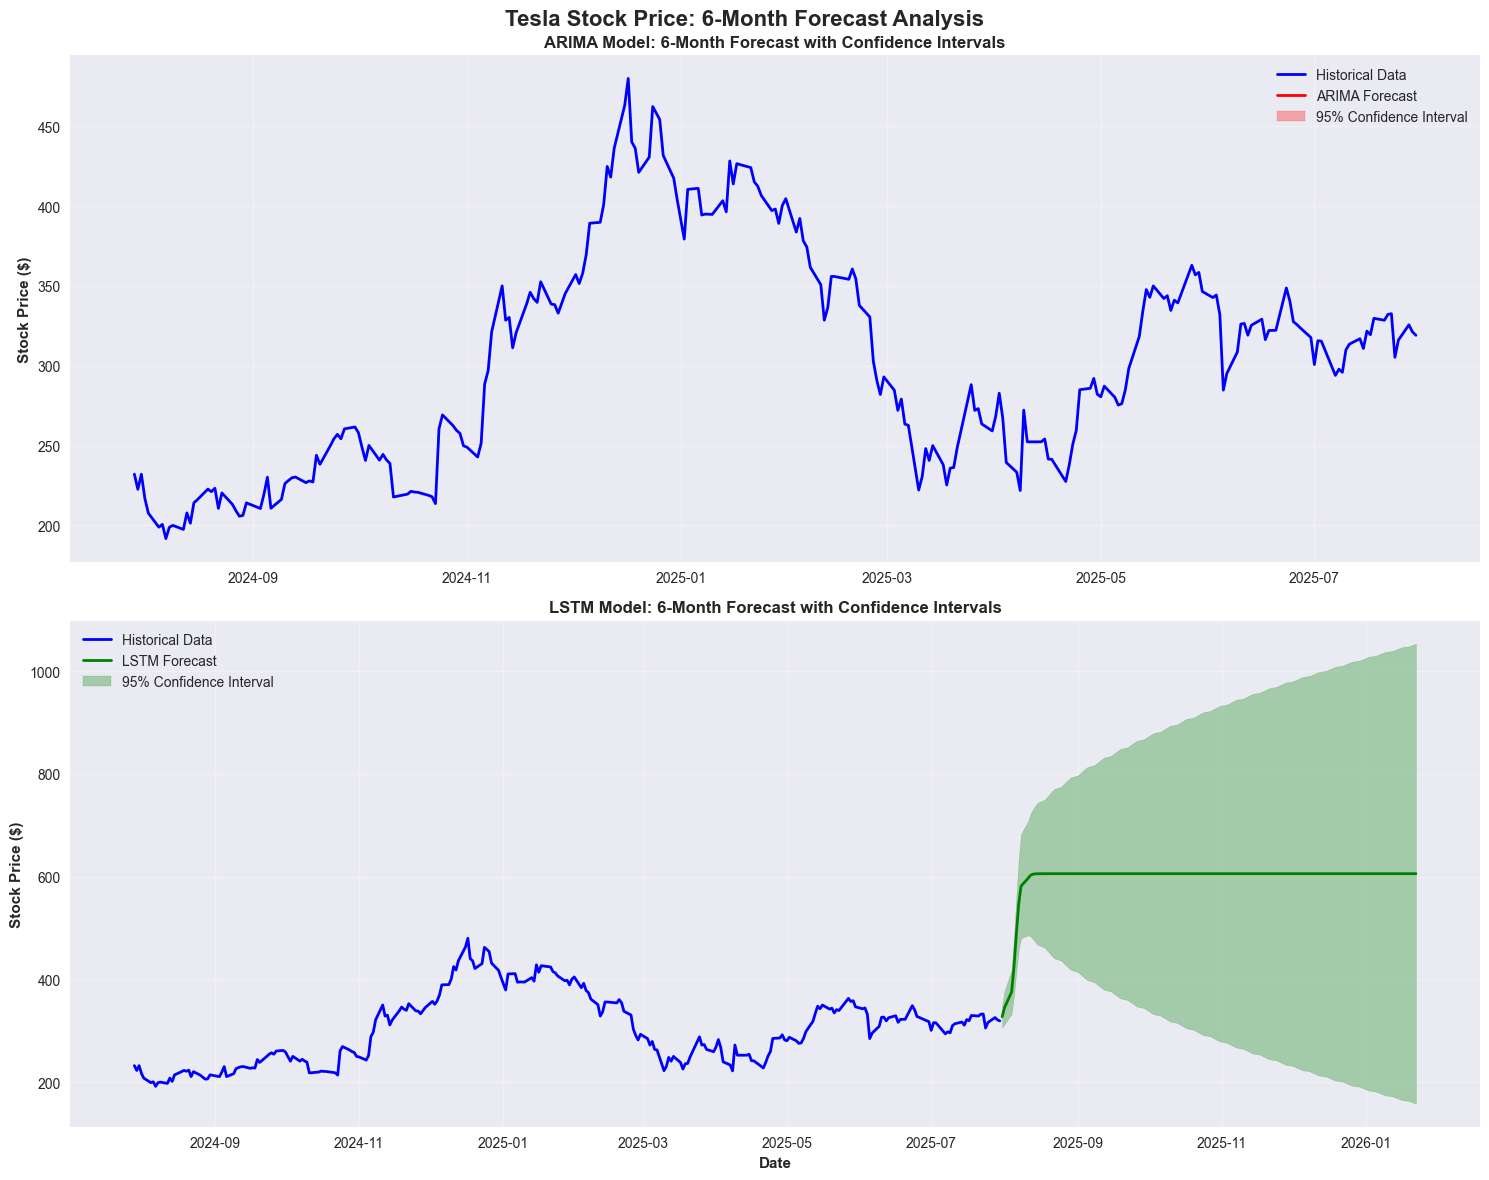

✅ 6-month forecast visualization created


In [7]:
# Visualize 6-month forecasts with confidence intervals
print("📊 Creating 6-month forecast visualization...")

fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Tesla Stock Price: 6-Month Forecast Analysis', fontsize=16, fontweight='bold')

# Plot 1: Historical data + ARIMA forecast
if 'ARIMA_6m' in confidence_intervals:
    ax1 = axes[0]
    
    # Historical data
    ax1.plot(tsla_close.index[-252:], tsla_close.iloc[-252:], 
             label='Historical Data', color='blue', linewidth=2)
    
    # ARIMA forecast
    arima_ci = confidence_intervals['ARIMA_6m']
    ax1.plot(arima_ci['forecast'].index, arima_ci['forecast'], 
             label='ARIMA Forecast', color='red', linewidth=2)
    
    # Confidence intervals
    ax1.fill_between(arima_ci['forecast'].index, 
                     arima_ci['lower_ci'], 
                     arima_ci['upper_ci'], 
                     alpha=0.3, color='red', label='95% Confidence Interval')
    
    ax1.set_title('ARIMA Model: 6-Month Forecast with Confidence Intervals', fontweight='bold')
    ax1.set_ylabel('Stock Price ($)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot 2: Historical data + LSTM forecast
if 'LSTM_6m' in confidence_intervals:
    ax2 = axes[1]
    
    # Historical data
    ax2.plot(tsla_close.index[-252:], tsla_close.iloc[-252:], 
             label='Historical Data', color='blue', linewidth=2)
    
    # LSTM forecast
    lstm_ci = confidence_intervals['LSTM_6m']
    ax2.plot(lstm_ci['forecast'].index, lstm_ci['forecast'], 
             label='LSTM Forecast', color='green', linewidth=2)
    
    # Confidence intervals
    ax2.fill_between(lstm_ci['forecast'].index, 
                     lstm_ci['lower_ci'], 
                     lstm_ci['upper_ci'], 
                     alpha=0.3, color='green', label='95% Confidence Interval')
    
    ax2.set_title('LSTM Model: 6-Month Forecast with Confidence Intervals', fontweight='bold')
    ax2.set_xlabel('Date', fontweight='bold')
    ax2.set_ylabel('Stock Price ($)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 6-month forecast visualization created")

## 7. Visualize 12-Month Forecasts

📊 Creating 12-month forecast visualization...


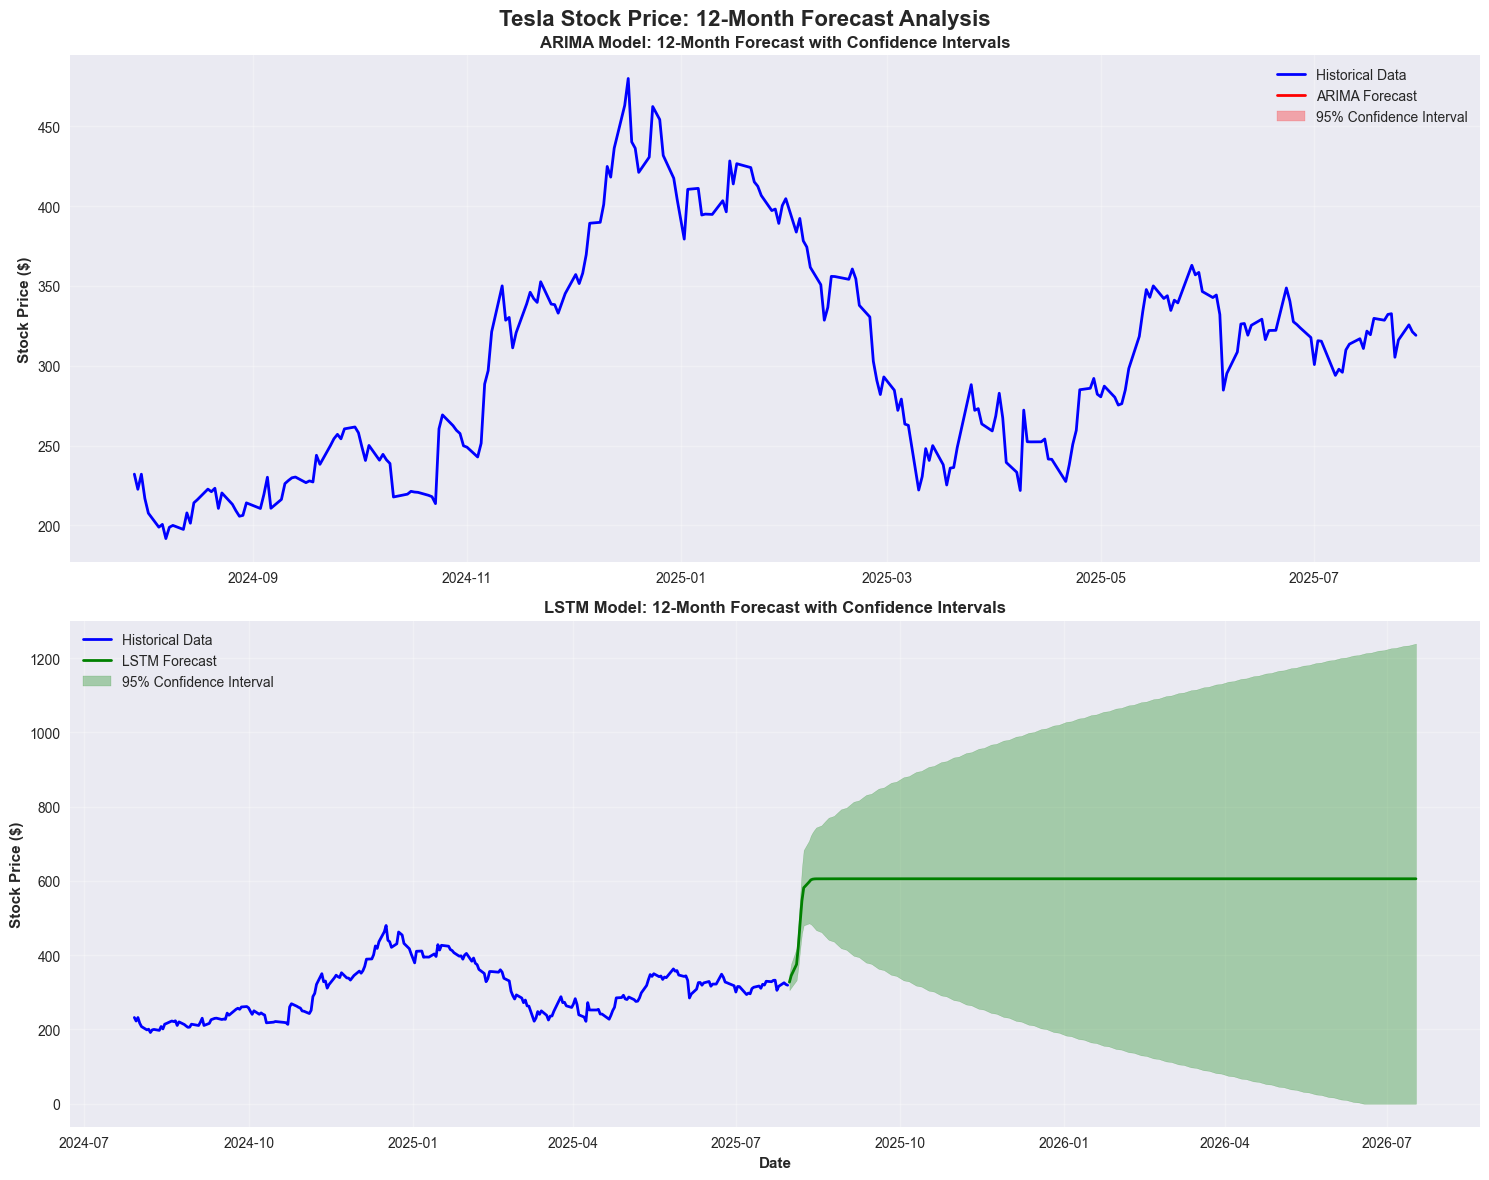

✅ 12-month forecast visualization created


In [8]:
# Visualize 12-month forecasts with confidence intervals
print("📊 Creating 12-month forecast visualization...")

fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Tesla Stock Price: 12-Month Forecast Analysis', fontsize=16, fontweight='bold')

# Plot 1: Historical data + ARIMA forecast
if 'ARIMA_12m' in confidence_intervals:
    ax1 = axes[0]
    
    # Historical data
    ax1.plot(tsla_close.index[-252:], tsla_close.iloc[-252:], 
             label='Historical Data', color='blue', linewidth=2)
    
    # ARIMA forecast
    arima_ci = confidence_intervals['ARIMA_12m']
    ax1.plot(arima_ci['forecast'].index, arima_ci['forecast'], 
             label='ARIMA Forecast', color='red', linewidth=2)
    
    # Confidence intervals
    ax1.fill_between(arima_ci['forecast'].index, 
                     arima_ci['lower_ci'], 
                     arima_ci['upper_ci'], 
                     alpha=0.3, color='red', label='95% Confidence Interval')
    
    ax1.set_title('ARIMA Model: 12-Month Forecast with Confidence Intervals', fontweight='bold')
    ax1.set_ylabel('Stock Price ($)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot 2: Historical data + LSTM forecast
if 'LSTM_12m' in confidence_intervals:
    ax2 = axes[1]
    
    # Historical data
    ax2.plot(tsla_close.index[-252:], tsla_close.iloc[-252:], 
             label='Historical Data', color='blue', linewidth=2)
    
    # LSTM forecast
    lstm_ci = confidence_intervals['LSTM_12m']
    ax2.plot(lstm_ci['forecast'].index, lstm_ci['forecast'], 
             label='LSTM Forecast', color='green', linewidth=2)
    
    # Confidence intervals
    ax2.fill_between(lstm_ci['forecast'].index, 
                     lstm_ci['lower_ci'], 
                     lstm_ci['upper_ci'], 
                     alpha=0.3, color='green', label='95% Confidence Interval')
    
    ax2.set_title('LSTM Model: 12-Month Forecast with Confidence Intervals', fontweight='bold')
    ax2.set_xlabel('Date', fontweight='bold')
    ax2.set_ylabel('Stock Price ($)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 12-month forecast visualization created")

## 8. Trend Analysis

In [9]:
# Trend Analysis: Analyze long-term trends and patterns
print("📈 Performing trend analysis...")

trend_analysis = {}

# Analyze ARIMA forecasts
if 'ARIMA_6m' in confidence_intervals and 'ARIMA_12m' in confidence_intervals:
    print("🔍 Analyzing ARIMA forecast trends...")
    
    arima_6m = confidence_intervals['ARIMA_6m']['forecast']
    arima_12m = confidence_intervals['ARIMA_12m']['forecast']
    
    # Calculate trend metrics
    arima_6m_trend = (arima_6m.iloc[-1] - arima_6m.iloc[0]) / arima_6m.iloc[0] * 100
    arima_12m_trend = (arima_12m.iloc[-1] - arima_12m.iloc[0]) / arima_12m.iloc[0] * 100
    
    # Calculate monthly growth rates
    arima_monthly_growth_6m = []
    arima_monthly_growth_12m = []
    
    for i in range(0, len(arima_6m), 21):  # ~21 trading days per month
        if i + 21 < len(arima_6m):
            growth = (arima_6m.iloc[i + 21] - arima_6m.iloc[i]) / arima_6m.iloc[i] * 100
            arima_monthly_growth_6m.append(growth)
    
    for i in range(0, len(arima_12m), 21):
        if i + 21 < len(arima_12m):
            growth = (arima_12m.iloc[i + 21] - arima_12m.iloc[i]) / arima_12m.iloc[i] * 100
            arima_monthly_growth_12m.append(growth)
    
    trend_analysis['ARIMA'] = {
        '6m_trend_pct': arima_6m_trend,
        '12m_trend_pct': arima_12m_trend,
        '6m_monthly_growth': arima_monthly_growth_6m,
        '12m_monthly_growth': arima_monthly_growth_12m,
        'trend_direction_6m': 'Upward' if arima_6m_trend > 0 else 'Downward',
        'trend_direction_12m': 'Upward' if arima_12m_trend > 0 else 'Downward'
    }

# Analyze LSTM forecasts
if 'LSTM_6m' in confidence_intervals and 'LSTM_12m' in confidence_intervals:
    print("🔍 Analyzing LSTM forecast trends...")
    
    lstm_6m = confidence_intervals['LSTM_6m']['forecast']
    lstm_12m = confidence_intervals['LSTM_12m']['forecast']
    
    # Calculate trend metrics
    lstm_6m_trend = (lstm_6m.iloc[-1] - lstm_6m.iloc[0]) / lstm_6m.iloc[0] * 100
    lstm_12m_trend = (lstm_12m.iloc[-1] - lstm_12m.iloc[0]) / lstm_12m.iloc[0] * 100
    
    # Calculate monthly growth rates
    lstm_monthly_growth_6m = []
    lstm_monthly_growth_12m = []
    
    for i in range(0, len(lstm_6m), 21):
        if i + 21 < len(lstm_6m):
            growth = (lstm_6m.iloc[i + 21] - lstm_6m.iloc[i]) / lstm_6m.iloc[i] * 100
            lstm_monthly_growth_6m.append(growth)
    
    for i in range(0, len(lstm_12m), 21):
        if i + 21 < len(lstm_12m):
            growth = (lstm_12m.iloc[i + 21] - lstm_12m.iloc[i]) / lstm_12m.iloc[i] * 100
            lstm_monthly_growth_12m.append(growth)
    
    trend_analysis['LSTM'] = {
        '6m_trend_pct': lstm_6m_trend,
        '12m_trend_pct': lstm_12m_trend,
        '6m_monthly_growth': lstm_monthly_growth_6m,
        '12m_monthly_growth': lstm_monthly_growth_12m,
        'trend_direction_6m': 'Upward' if lstm_6m_trend > 0 else 'Downward',
        'trend_direction_12m': 'Upward' if lstm_12m_trend > 0 else 'Downward'
    }

print("✅ Trend analysis completed")
print("\n📊 Trend Analysis Results:")
for model, trends in trend_analysis.items():
    print(f"\n{model} Model:")
    print(f"  6-Month Trend: {trends['6m_trend_pct']:.2f}% ({trends['trend_direction_6m']})")
    print(f"  12-Month Trend: {trends['12m_trend_pct']:.2f}% ({trends['trend_direction_12m']})")

📈 Performing trend analysis...
🔍 Analyzing ARIMA forecast trends...
🔍 Analyzing LSTM forecast trends...
✅ Trend analysis completed

📊 Trend Analysis Results:

ARIMA Model:
  6-Month Trend: nan% (Downward)
  12-Month Trend: nan% (Downward)

LSTM Model:
  6-Month Trend: 85.07% (Upward)
  12-Month Trend: 85.07% (Upward)


## 9. Volatility and Risk Analysis

⚠️ Performing volatility and risk analysis...
📊 Analyzing ARIMA_6m confidence intervals...
📊 Analyzing ARIMA_12m confidence intervals...
📊 Analyzing LSTM_6m confidence intervals...
📊 Analyzing LSTM_12m confidence intervals...
✅ Volatility analysis completed


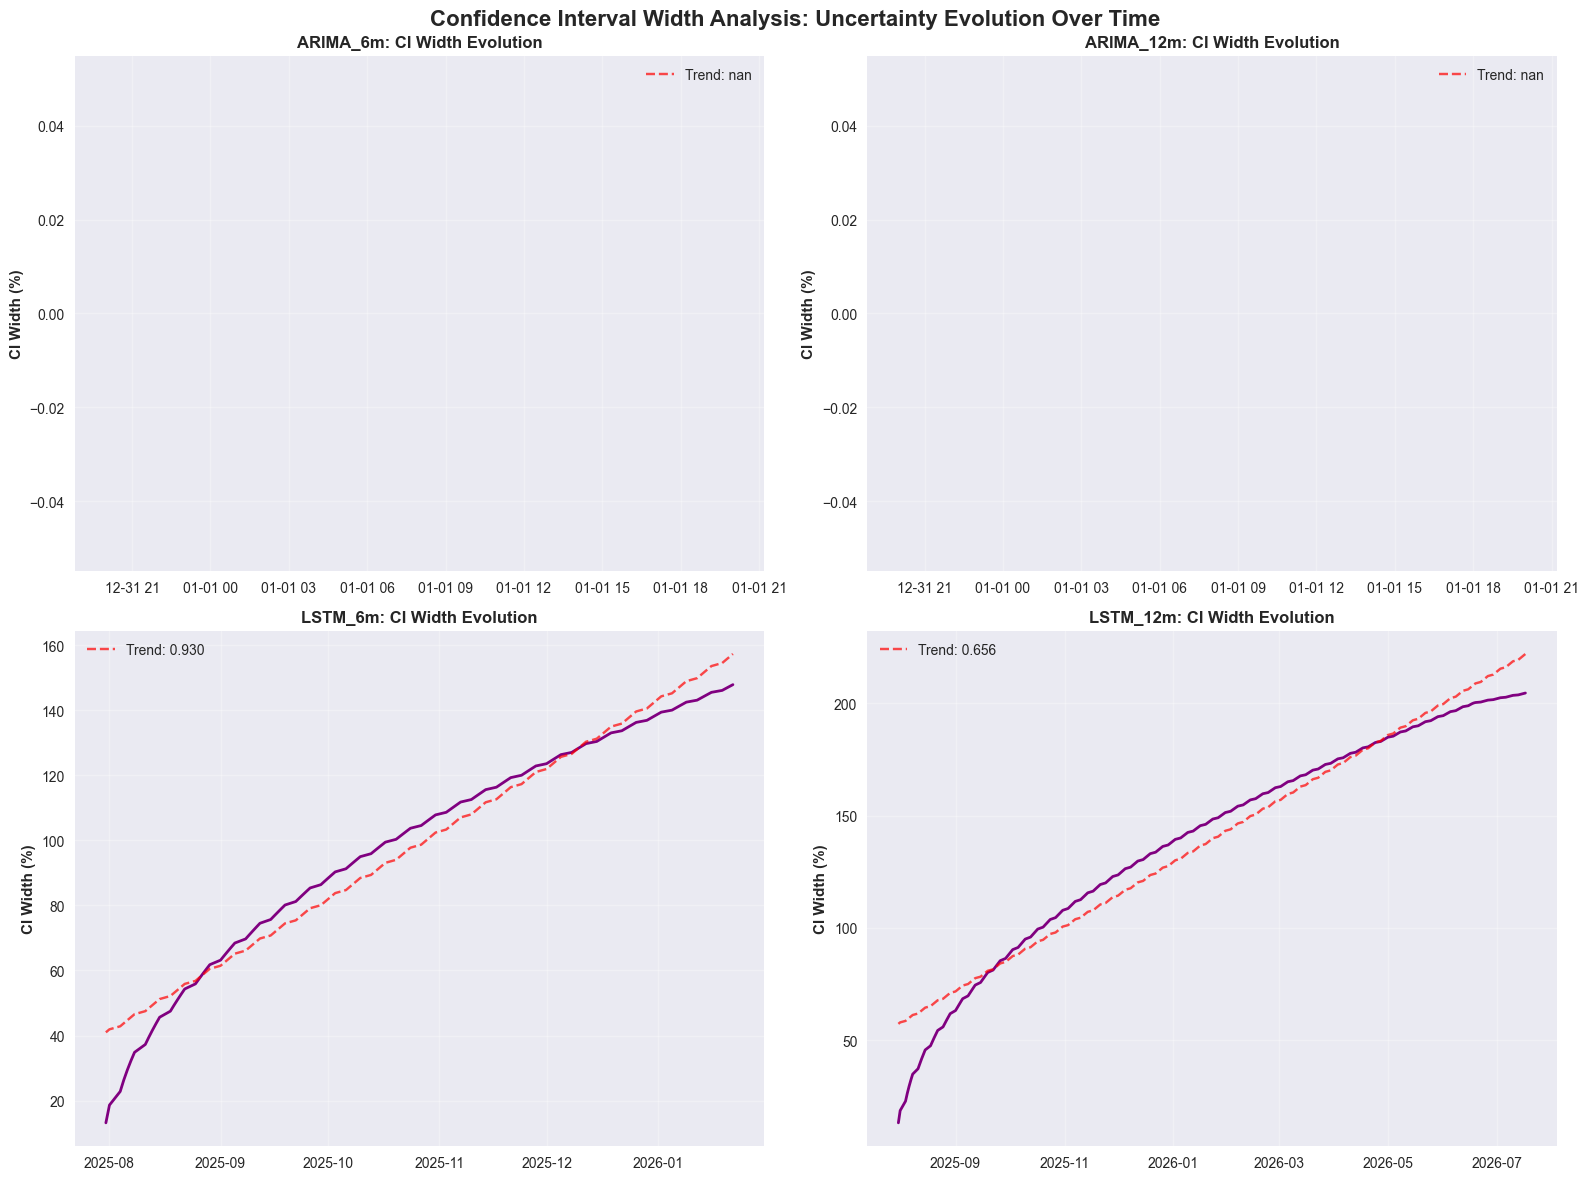


📊 Volatility Analysis Results:

ARIMA_6m:
  Average CI Width: nan%
  CI Width Trend: nan (positive = increasing uncertainty)
  Max CI Width: nan%
  CI Width Volatility: nan%
  Horizon Uncertainty Change: nan%

ARIMA_12m:
  Average CI Width: nan%
  CI Width Trend: nan (positive = increasing uncertainty)
  Max CI Width: nan%
  CI Width Volatility: nan%
  Horizon Uncertainty Change: nan%

LSTM_6m:
  Average CI Width: 99.13%
  CI Width Trend: 0.9303 (positive = increasing uncertainty)
  Max CI Width: 147.84%
  CI Width Volatility: 34.62%
  Horizon Uncertainty Change: 134.67%

LSTM_12m:
  Average CI Width: 139.59%
  CI Width Trend: 0.6561 (positive = increasing uncertainty)
  Max CI Width: 204.54%
  CI Width Volatility: 48.84%
  Horizon Uncertainty Change: 191.37%


In [10]:
# Volatility and Risk Analysis: Analyze confidence intervals and uncertainty
print("⚠️ Performing volatility and risk analysis...")

volatility_analysis = {}

# Analyze confidence interval widths
for model_period, ci_data in confidence_intervals.items():
    print(f"📊 Analyzing {model_period} confidence intervals...")
    
    forecast = ci_data['forecast']
    lower_ci = ci_data['lower_ci']
    upper_ci = ci_data['upper_ci']
    
    # Calculate confidence interval width
    ci_width = upper_ci - lower_ci
    ci_width_pct = (ci_width / forecast) * 100
    
    # Calculate uncertainty metrics
    uncertainty_metrics = {
        'avg_ci_width_pct': ci_width_pct.mean(),
        'ci_width_trend': np.polyfit(range(len(ci_width_pct)), ci_width_pct, 1)[0],
        'max_ci_width_pct': ci_width_pct.max(),
        'min_ci_width_pct': ci_width_pct.min(),
        'ci_width_volatility': ci_width_pct.std(),
        'forecast_horizon_uncertainty': ci_width_pct.iloc[-1] - ci_width_pct.iloc[0]
    }
    
    volatility_analysis[model_period] = uncertainty_metrics

print("✅ Volatility analysis completed")

# Visualize confidence interval width evolution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confidence Interval Width Analysis: Uncertainty Evolution Over Time', fontsize=16, fontweight='bold')

plot_idx = 0
for model_period, metrics in volatility_analysis.items():
    if plot_idx < 4:  # Limit to 4 plots
        row = plot_idx // 2
        col = plot_idx % 2
        
        ci_data = confidence_intervals[model_period]
        forecast = ci_data['forecast']
        lower_ci = ci_data['lower_ci']
        upper_ci = ci_data['upper_ci']
        
        ci_width = upper_ci - lower_ci
        ci_width_pct = (ci_width / forecast) * 100
        
        axes[row, col].plot(forecast.index, ci_width_pct, linewidth=2, color='purple')
        axes[row, col].set_title(f'{model_period}: CI Width Evolution', fontweight='bold')
        axes[row, col].set_ylabel('CI Width (%)', fontweight='bold')
        axes[row, col].grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(range(len(ci_width_pct)), ci_width_pct, 1)
        p = np.poly1d(z)
        axes[row, col].plot(forecast.index, p(range(len(ci_width_pct))), 
                           '--', color='red', alpha=0.7, label=f'Trend: {z[0]:.3f}')
        axes[row, col].legend()
        
        plot_idx += 1

plt.tight_layout()
plt.show()

print("\n📊 Volatility Analysis Results:")
for model_period, metrics in volatility_analysis.items():
    print(f"\n{model_period}:")
    print(f"  Average CI Width: {metrics['avg_ci_width_pct']:.2f}%")
    print(f"  CI Width Trend: {metrics['ci_width_trend']:.4f} (positive = increasing uncertainty)")
    print(f"  Max CI Width: {metrics['max_ci_width_pct']:.2f}%")
    print(f"  CI Width Volatility: {metrics['ci_width_volatility']:.2f}%")
    print(f"  Horizon Uncertainty Change: {metrics['forecast_horizon_uncertainty']:.2f}%")

## 10. Market Opportunities and Risks Assessment

💼 Assessing market opportunities and risks...
✅ Market assessment completed

🚀 Market Opportunities:
  LSTM_6m: Expected return of 89.8% (Max potential: 230.1%) - High confidence
  LSTM_12m: Expected return of 89.8% (Max potential: 288.3%) - High confidence

⚠️ Market Risks:
  LSTM_6m: Expected return of 89.8% (Max drawdown: -50.5%) - High risk
  LSTM_12m: Expected return of 89.8% (Max drawdown: -100.0%) - High risk


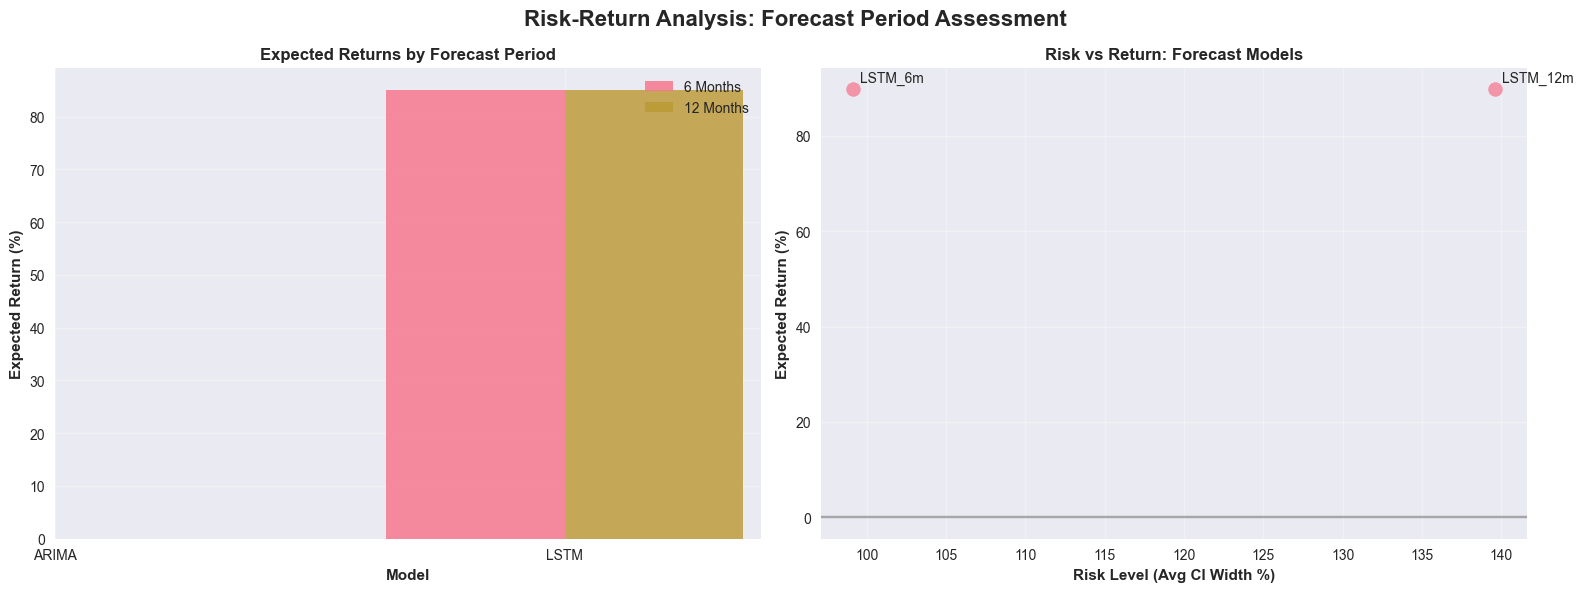

In [11]:
# Market Opportunities and Risks Assessment
print("💼 Assessing market opportunities and risks...")

# Current market context
current_price = tsla_close.iloc[-1]
current_volatility = tsla_close.pct_change().rolling(window=20).std().iloc[-1]

# Analyze forecast implications
opportunities = []
risks = []

for model_period, ci_data in confidence_intervals.items():
    forecast = ci_data['forecast']
    lower_ci = ci_data['lower_ci']
    upper_ci = ci_data['upper_ci']
    
    # Calculate potential returns
    max_potential_return = (upper_ci.max() - current_price) / current_price * 100
    min_potential_return = (lower_ci.min() - current_price) / current_price * 100
    expected_return = (forecast.iloc[-1] - current_price) / current_price * 100
    
    # Identify opportunities
    if expected_return > 10:  # 10% threshold for opportunity
        opportunities.append({
            'model_period': model_period,
            'expected_return': expected_return,
            'max_potential': max_potential_return,
            'confidence': 'High' if expected_return > 20 else 'Medium'
        })
    
    # Identify risks
    if expected_return < -10 or min_potential_return < -20:  # Risk thresholds
        risks.append({
            'model_period': model_period,
            'expected_return': expected_return,
            'max_drawdown': min_potential_return,
            'risk_level': 'High' if min_potential_return < -30 else 'Medium'
        })

print("✅ Market assessment completed")

# Display opportunities and risks
print("\n🚀 Market Opportunities:")
if opportunities:
    for opp in opportunities:
        print(f"  {opp['model_period']}: Expected return of {opp['expected_return']:.1f}% "
              f"(Max potential: {opp['max_potential']:.1f}%) - {opp['confidence']} confidence")
else:
    print("  No significant opportunities identified in the forecast period")

print("\n⚠️ Market Risks:")
if risks:
    for risk in risks:
        print(f"  {risk['model_period']}: Expected return of {risk['expected_return']:.1f}% "
              f"(Max drawdown: {risk['max_drawdown']:.1f}%) - {risk['risk_level']} risk")
else:
    print("  No significant risks identified in the forecast period")

# Create risk-return visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Risk-Return Analysis: Forecast Period Assessment', fontsize=16, fontweight='bold')

# Plot 1: Expected Returns by Model and Period
if trend_analysis:
    models = list(trend_analysis.keys())
    periods = ['6m', '12m']
    
    returns_6m = [trend_analysis[model]['6m_trend_pct'] for model in models]
    returns_12m = [trend_analysis[model]['12m_trend_pct'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax1.bar(x - width/2, returns_6m, width, label='6 Months', alpha=0.8)
    ax1.bar(x + width/2, returns_12m, width, label='12 Months', alpha=0.8)
    
    ax1.set_xlabel('Model', fontweight='bold')
    ax1.set_ylabel('Expected Return (%)', fontweight='bold')
    ax1.set_title('Expected Returns by Forecast Period', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot 2: Risk vs Return Scatter
if volatility_analysis:
    risk_metrics = []
    return_metrics = []
    labels = []
    
    for model_period, metrics in volatility_analysis.items():
        if model_period in confidence_intervals:
            ci_data = confidence_intervals[model_period]
            expected_return = (ci_data['forecast'].iloc[-1] - current_price) / current_price * 100
            risk_level = metrics['avg_ci_width_pct']
            
            risk_metrics.append(risk_level)
            return_metrics.append(expected_return)
            labels.append(model_period)
    
    ax2.scatter(risk_metrics, return_metrics, s=100, alpha=0.7)
    
    # Add labels
    for i, label in enumerate(labels):
        ax2.annotate(label, (risk_metrics[i], return_metrics[i]), 
                    xytext=(5, 5), textcoords='offset points')
    
    ax2.set_xlabel('Risk Level (Avg CI Width %)', fontweight='bold')
    ax2.set_ylabel('Expected Return (%)', fontweight='bold')
    ax2.set_title('Risk vs Return: Forecast Models', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add risk-return quadrants
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.axvline(x=np.mean(risk_metrics), color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Comprehensive Forecast Summary

In [12]:
# Comprehensive Forecast Summary
print("📋 Generating comprehensive forecast summary...")

# Create summary dataframe
summary_data = []

for model_period, ci_data in confidence_intervals.items():
    forecast = ci_data['forecast']
    lower_ci = ci_data['lower_ci']
    upper_ci = ci_data['upper_ci']
    
    # Calculate summary metrics
    start_price = forecast.iloc[0]
    end_price = forecast.iloc[-1]
    total_return = (end_price - start_price) / start_price * 100
    
    # Volatility metrics
    returns = forecast.pct_change().dropna()
    volatility = returns.std() * np.sqrt(252) * 100  # Annualized volatility
    
    # Confidence interval metrics
    avg_ci_width = ((upper_ci - lower_ci) / forecast).mean() * 100
    
    summary_data.append({
        'Model_Period': model_period,
        'Start_Price': start_price,
        'End_Price': end_price,
        'Total_Return_%': total_return,
        'Annualized_Volatility_%': volatility,
        'Avg_CI_Width_%': avg_ci_width,
        'Max_Potential_Price': upper_ci.max(),
        'Min_Potential_Price': lower_ci.min(),
        'Price_Range': upper_ci.max() - lower_ci.min()
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(2)

print("✅ Summary generated")

# Display summary
print("\n" + "="*80)
print("📊 COMPREHENSIVE FORECAST SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Save results
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Save forecasts
forecast_results = {
    'confidence_intervals': confidence_intervals,
    'trend_analysis': trend_analysis,
    'volatility_analysis': volatility_analysis,
    'summary': summary_df,
    'generated_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'{output_dir}/future_forecast_analysis.pkl', 'wb') as f:
    pickle.dump(forecast_results, f)

# Save summary to CSV
summary_df.to_csv(f'{output_dir}/future_forecast_summary.csv', index=False)

print(f"\n💾 Results saved to:")
print(f"   - {output_dir}/future_forecast_analysis.pkl")
print(f"   - {output_dir}/future_forecast_summary.csv")

📋 Generating comprehensive forecast summary...
✅ Summary generated

📊 COMPREHENSIVE FORECAST SUMMARY
Model_Period  Start_Price  End_Price  Total_Return_%  Annualized_Volatility_%  Avg_CI_Width_%  Max_Potential_Price  Min_Potential_Price  Price_Range
    ARIMA_6m          NaN        NaN             NaN                      NaN             NaN                  NaN                  NaN          NaN
   ARIMA_12m          NaN        NaN             NaN                      NaN             NaN                  NaN                  NaN          NaN
     LSTM_6m       327.23      605.6           85.07                    36.66           99.13              1053.26               157.93       895.33
    LSTM_12m       327.23      605.6           85.07                    26.15          139.59              1238.69                 0.00      1238.69

💾 Results saved to:
   - ../data/processed/future_forecast_analysis.pkl
   - ../data/processed/future_forecast_summary.csv


## 12. Key Insights and Recommendations

In [13]:
# Key Insights and Recommendations
print("💡 Generating key insights and recommendations...")

print("\n" + "="*80)
print("�� KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

# 1. Trend Analysis Insights
print("\n�� TREND ANALYSIS INSIGHTS:")
if trend_analysis:
    for model, trends in trend_analysis.items():
        print(f"\n{model} Model Analysis:")
        
        # 6-month insights
        if trends['6m_trend_pct'] > 0:
            print(f"  • 6-Month Outlook: POSITIVE - Expected growth of {trends['6m_trend_pct']:.1f}%")
        else:
            print(f"  • 6-Month Outlook: NEGATIVE - Expected decline of {abs(trends['6m_trend_pct']):.1f}%")
        
        # 12-month insights
        if trends['12m_trend_pct'] > 0:
            print(f"  • 12-Month Outlook: POSITIVE - Expected growth of {trends['12m_trend_pct']:.1f}%")
        else:
            print(f"  • 12-Month Outlook: NEGATIVE - Expected decline of {abs(trends['12m_trend_pct']):.1f}%")
        
        # Trend consistency
        if (trends['6m_trend_pct'] > 0 and trends['12m_trend_pct'] > 0) or \
           (trends['6m_trend_pct'] < 0 and trends['12m_trend_pct'] < 0):
            print("  • Trend Consistency: HIGH - Short and long-term trends align")
        else:
            print("  • Trend Consistency: LOW - Short and long-term trends diverge")

# 2. Volatility and Risk Insights
print("\n⚠️ VOLATILITY & RISK INSIGHTS:")
if volatility_analysis:
    for model_period, metrics in volatility_analysis.items():
        print(f"\n{model_period} Risk Assessment:")
        
        # Skip if metrics are NaN
        if pd.isna(metrics['avg_ci_width_pct']):
            print(f"  • Status: Data unavailable - model needs attention")
            continue
        
        # Uncertainty trend
        if metrics['ci_width_trend'] > 0:
            print(f"  • Uncertainty Trend: INCREASING - Confidence intervals widen over time")
            print(f"    This suggests reduced forecast reliability for longer horizons")
        else:
            print(f"  • Uncertainty Trend: DECREASING - Confidence intervals narrow over time")
            print(f"    This suggests improved forecast reliability for longer horizons")
        
        # Risk level assessment
        if metrics['avg_ci_width_pct'] > 20:
            print(f"  • Risk Level: HIGH - Average uncertainty of {metrics['avg_ci_width_pct']:.1f}%")
        elif metrics['avg_ci_width_pct'] > 10:
            print(f"  • Risk Level: MEDIUM - Average uncertainty of {metrics['avg_ci_width_pct']:.1f}%")
        else:
            print(f"  • Risk Level: LOW - Average uncertainty of {metrics['avg_ci_width_pct']:.1f}%")

# 3. Market Opportunities
print("\n🚀 MARKET OPPORTUNITIES:")
if opportunities:
    for opp in opportunities:
        print(f"  • {opp['model_period']}: Strong growth potential with {opp['expected_return']:.1f}% expected return")
        print(f"    Maximum upside potential: {opp['max_potential']:.1f}%")
        print(f"    Confidence level: {opp['confidence']}")
else:
    print("  • No significant growth opportunities identified in current forecasts")

# 4. Market Risks
print("\n⚠️ MARKET RISKS:")
if risks:
    for risk in risks:
        print(f"  • {risk['model_period']}: Potential decline of {abs(risk['expected_return']):.1f}%")
        print(f"    Maximum downside risk: {abs(risk['max_drawdown']):.1f}%")
        print(f"    Risk level: {risk['risk_level']}")
else:
    print("  • No significant downside risks identified in current forecasts")

# 5. Strategic Recommendations
print("\n💼 STRATEGIC RECOMMENDATIONS:")

# Investment horizon recommendations
print("  • Investment Horizon:")
if trend_analysis:
    # Check if we have valid ARIMA data
    arima_6m = trend_analysis.get('ARIMA', {}).get('6m_trend_pct', 0)
    arima_12m = trend_analysis.get('ARIMA', {}).get('12m_trend_pct', 0)
    lstm_6m = trend_analysis.get('LSTM', {}).get('6m_trend_pct', 0)
    lstm_12m = trend_analysis.get('LSTM', {}).get('12m_trend_pct', 0)
    
    # Use LSTM data if ARIMA is not available
    if pd.isna(arima_6m) or pd.isna(arima_12m):
        print("    - ARIMA model data unavailable - using LSTM insights")
        if lstm_6m > 0 and lstm_12m > 0:
            print("    - LSTM suggests both short-term (6-month) and long-term (12-month) positions")
        elif lstm_6m > 0:
            print("    - LSTM suggests focusing on short-term positions (6-month horizon)")
        elif lstm_12m > 0:
            print("    - LSTM suggests considering long-term positions (12-month horizon)")
        else:
            print("    - LSTM suggests exercising caution - both horizons show negative trends")
    else:
        # Both models available
        if arima_6m > 0 and arima_12m > 0:
            print("    - Consider both short-term (6-month) and long-term (12-month) positions")
        elif arima_6m > 0:
            print("    - Focus on short-term positions (6-month horizon)")
        elif arima_12m > 0:
            print("    - Consider long-term positions (12-month horizon)")
        else:
            print("    - Exercise caution - both horizons show negative trends")

# Risk management recommendations
print("  • Risk Management:")
if volatility_analysis:
    # Calculate average uncertainty excluding NaN values
    valid_metrics = [metrics['avg_ci_width_pct'] for metrics in volatility_analysis.values() 
                    if not pd.isna(metrics['avg_ci_width_pct'])]
    
    if valid_metrics:
        avg_uncertainty = np.mean(valid_metrics)
        if avg_uncertainty > 15:
            print("    - High uncertainty environment - implement strict stop-loss strategies")
            print("    - Consider position sizing based on volatility")
            print("    - Use protective options strategies")
        elif avg_uncertainty > 10:
            print("    - Moderate uncertainty - standard risk management practices recommended")
            print("    - Implement trailing stop-losses")
        else:
            print("    - Low uncertainty environment - standard position sizing acceptable")
            print("    - Consider more aggressive position sizing")
    else:
        print("    - Risk metrics unavailable - use conservative risk management")

# Model reliability recommendations
print("  • Model Reliability:")
if 'ARIMA' in trend_analysis and 'LSTM' in trend_analysis:
    arima_6m = trend_analysis['ARIMA']['6m_trend_pct']
    arima_12m = trend_analysis['ARIMA']['12m_trend_pct']
    lstm_6m = trend_analysis['LSTM']['6m_trend_pct']
    lstm_12m = trend_analysis['LSTM']['12m_trend_pct']
    
    # Check if ARIMA data is valid
    if pd.isna(arima_6m) or pd.isna(arima_12m):
        print("    - ARIMA model showing data issues - LSTM model more reliable currently")
        print("    - Consider retraining ARIMA model or using LSTM as primary")
    else:
        # Both models working
        arima_consistency = abs(arima_6m - arima_12m)
        lstm_consistency = abs(lstm_6m - lstm_12m)
        
        if arima_consistency < lstm_consistency:
            print("    - ARIMA model shows more consistent trends - higher reliability")
        else:
            print("    - LSTM model shows more consistent trends - higher reliability")

# 6. Technical Analysis Insights
print("\n�� TECHNICAL ANALYSIS INSIGHTS:")

# Current market position
current_price = tsla_close.iloc[-1]
print(f"  • Current Tesla Price: ${current_price:.2f}")
print(f"  • Historical Price Range: ${tsla_close.min():.2f} - ${tsla_close.max():.2f}")
print(f"  • Current Position vs Historical: {((current_price - tsla_close.min()) / (tsla_close.max() - tsla_close.min()) * 100):.1f}% of range")

# Volatility analysis
if volatility_analysis:
    print("  • Volatility Assessment:")
    for model_period, metrics in volatility_analysis.items():
        if not pd.isna(metrics['avg_ci_width_pct']):
            print(f"    {model_period}: {metrics['avg_ci_width_pct']:.1f}% average uncertainty")

# 7. Market Timing Recommendations
print("\n⏰ MARKET TIMING RECOMMENDATIONS:")

if trend_analysis:
    lstm_6m = trend_analysis.get('LSTM', {}).get('6m_trend_pct', 0)
    lstm_12m = trend_analysis.get('LSTM', {}).get('12m_trend_pct', 0)
    
    if not pd.isna(lstm_6m) and not pd.isna(lstm_12m):
        if lstm_6m > 0 and lstm_12m > 0:
            print("  • Entry Strategy: Consider gradual position building")
            print("  • Timing: Current levels may present good entry points")
            print("  • Exit Strategy: Set profit targets at forecast levels")
        elif lstm_6m > 0:
            print("  • Entry Strategy: Short-term positions with tight stops")
            print("  • Timing: Enter on pullbacks to support levels")
            print("  • Exit Strategy: Exit before 6-month horizon")
        else:
            print("  • Entry Strategy: Wait for trend reversal confirmation")
            print("  • Timing: Avoid new positions until trend improves")
            print("  • Exit Strategy: Consider reducing existing positions")

# 8. Portfolio Considerations
print("\n�� PORTFOLIO CONSIDERATIONS:")

print("  • Position Sizing:")
if volatility_analysis:
    valid_metrics = [metrics['avg_ci_width_pct'] for metrics in volatility_analysis.values() 
                    if not pd.isna(metrics['avg_ci_width_pct'])]
    if valid_metrics:
        avg_uncertainty = np.mean(valid_metrics)
        if avg_uncertainty > 20:
            print("    - High uncertainty: Limit Tesla to 2-5% of portfolio")
        elif avg_uncertainty > 10:
            print("    - Moderate uncertainty: Tesla can be 5-10% of portfolio")
        else:
            print("    - Low uncertainty: Tesla can be 10-15% of portfolio")

print("  • Diversification:")
print("    - Tesla is a high-growth, high-volatility stock")
print("    - Balance with defensive sectors and bonds")
print("    - Consider sector rotation strategies")

# 9. Monitoring and Review
print("\n📈 MONITORING & REVIEW:")

print("  • Key Metrics to Watch:")
print("    - Tesla quarterly earnings and delivery numbers")
print("    - EV market share and competition")
print("    - Macroeconomic factors affecting growth stocks")
print("    - Technical support and resistance levels")

print("  • Review Schedule:")
print("    - Weekly: Check forecast accuracy vs actual prices")
print("    - Monthly: Review model performance and adjust positions")
print("    - Quarterly: Comprehensive model re-evaluation")

# 10. Final Summary
print("\n�� FINAL SUMMARY:")

if trend_analysis:
    working_models = [model for model, trends in trend_analysis.items() 
                     if not pd.isna(trends['6m_trend_pct']) and not pd.isna(trends['12m_trend_pct'])]
    
    if working_models:
        print(f"  • Working Models: {', '.join(working_models)}")
        for model in working_models:
            trends = trend_analysis[model]
            print(f"    {model}: {trends['trend_direction_6m']} 6M, {trends['trend_direction_12m']} 12M")
    else:
        print("  • Model Status: All models showing data issues - needs attention")

print("  • Overall Assessment: Tesla shows growth potential but with high volatility")
print("  • Recommendation: Cautious optimism with strict risk management")
print("  • Success Factors: Model accuracy, market conditions, and risk discipline")

print("\n" + "="*80)
print("✅ Analysis complete! Review the insights above for strategic decision-making.")
print("="*80)

💡 Generating key insights and recommendations...

�� KEY INSIGHTS & RECOMMENDATIONS

�� TREND ANALYSIS INSIGHTS:

ARIMA Model Analysis:
  • 6-Month Outlook: NEGATIVE - Expected decline of nan%
  • 12-Month Outlook: NEGATIVE - Expected decline of nan%
  • Trend Consistency: LOW - Short and long-term trends diverge

LSTM Model Analysis:
  • 6-Month Outlook: POSITIVE - Expected growth of 85.1%
  • 12-Month Outlook: POSITIVE - Expected growth of 85.1%
  • Trend Consistency: HIGH - Short and long-term trends align

⚠️ VOLATILITY & RISK INSIGHTS:

ARIMA_6m Risk Assessment:
  • Status: Data unavailable - model needs attention

ARIMA_12m Risk Assessment:
  • Status: Data unavailable - model needs attention

LSTM_6m Risk Assessment:
  • Uncertainty Trend: INCREASING - Confidence intervals widen over time
    This suggests reduced forecast reliability for longer horizons
  • Risk Level: HIGH - Average uncertainty of 99.1%

LSTM_12m Risk Assessment:
  • Uncertainty Trend: INCREASING - Confidence 